In [44]:
from pyspark.sql import SparkSession
import pyspark.sql.types as t
import pyspark.sql.functions as f
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

In [2]:
files = glob('/app/data/*/*.csv')
files

['/app/data/2023-07/2023-07-12 06:00:00.000000 - 2023-07-13 23:59:59.999999.csv',
 '/app/data/2023-07/2023-07-08 18:00:00.000000 - 2023-07-10 11:59:59.999999.csv',
 '/app/data/2023-07/2023-07-07 00:00:00.000000 - 2023-07-08 17:59:59.999999.csv',
 '/app/data/2023-07/2023-07-10 12:00:00.000000 - 2023-07-12 05:59:59.999999.csv',
 '/app/data/2024-07/2024-07-12 06:00:00 - 2024-07-13 23:59:59.999999.csv',
 '/app/data/2024-07/2024-07-10 12:00:00 - 2024-07-12 05:59:59.999999.csv',
 '/app/data/2024-07/2024-07-08 18:00:00 - 2024-07-10 11:59:59.999999.csv',
 '/app/data/2024-07/1.csv',
 '/app/data/2022-07/2022-07-07 00:00:00 - 2022-07-08 17:59:59.999999.csv',
 '/app/data/2022-07/2022-07-08 18:00:00 - 2022-07-10 11:59:59.999999.csv',
 '/app/data/2022-07/2022-07-12 06:00:00 - 2022-07-13 23:59:59.999999.csv',
 '/app/data/2022-07/2022-07-10 12:00:00 - 2022-07-12 05:59:59.999999.csv',
 '/app/data/2021-07/2021-07-08 18:00:00 - 2021-07-10 11:59:59.999999.csv',
 '/app/data/2021-07/2021-07-10 12:00:00 - 20

In [3]:
spark = SparkSession.builder\
    .appName("TestJob")\
    .master("spark://spark-master:7077")\
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/06 12:16:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
schema = t.StructType([
    t.StructField('record_type', t.StringType()),
    t.StructField('type', t.StringType()),
    t.StructField('time', t.DoubleType()),
    t.StructField('project', t.StringType()),
    t.StructField('collector', t.StringType()),
    t.StructField('router', t.StringType()),
    t.StructField('router_ip', t.StringType()),
    t.StructField('peer_asn', t.IntegerType()),
    t.StructField('peer_address', t.StringType()),
    t.StructField('prefix', t.StringType()),
    t.StructField('next_hop', t.StringType()),
    t.StructField('as_path', t.StringType()),
    t.StructField('communities', t.StringType()),
])

df = spark.read.csv('/app/data/2024-07/1.csv', header=True, schema=schema)

In [5]:
df.show(10)

+-----------+----+-------------------+----------+----------------+------+---------+--------+--------------------+-------------------+--------------------+--------------------+--------------------+
|record_type|type|               time|   project|       collector|router|router_ip|peer_asn|        peer_address|             prefix|            next_hop|             as_path|         communities|
+-----------+----+-------------------+----------+----------------+------+---------+--------+--------------------+-------------------+--------------------+--------------------+--------------------+
|     update|   W|1.720310400067833E9|routeviews|route-views.eqix|  NULL|     NULL|   16552|2001:504:0:2:0:1:...|2a06:de05:626b::/48|                NULL|                NULL|                NULL|
|     update|   W|1.720310400067833E9|routeviews|route-views.eqix|  NULL|     NULL|   16552|2001:504:0:2:0:1:...|2a06:de05:62c5::/48|                NULL|                NULL|                NULL|
|     update|  

In [6]:
start_unixtime = dt.datetime(2024, 7, 7).timestamp()
end_unixtime = dt.datetime(2024, 7, 8).timestamp()

In [7]:
df_period = df.filter((df.time >= start_unixtime) & (df.time < end_unixtime))

In [8]:
df_enriched = df_period.withColumn('datetime', f.from_unixtime('time'))\
                       .withColumn('hour', f.date_trunc('hour', 'datetime'))\
                       .withColumn('as_path_split', f.split('as_path', ' '))\
                       .withColumn(
                           'origin_asn', 
                            f.get('as_path_split', f.size('as_path_split') - 1).cast(t.IntegerType())
                       )\
                       .drop('as_path_split')

In [10]:
df_agg = df_enriched.groupBy('hour')\
                    .agg(
                       f.countDistinct('peer_asn').alias('unique_peers'),
                       f.countDistinct('origin_asn').alias('unique_origins'),
                       f.countDistinct('prefix').alias('unique_prefixes'),
                       f.count('time').alias('updates')
                    )\
                    .sort(f.asc('hour'))

In [12]:
df_agg_pd = df_agg.toPandas()

In [22]:
df_agg_pd['hour'] = pd.to_datetime(df_agg_pd['hour'])
df_agg_pd = df_agg_pd.sort_values('hour')
df_agg_pd

,hour,unique_peers,unique_origins,unique_prefixes,updates
23,2024-07-07 00:00:00,26,8128,49625,1378445
4,2024-07-07 01:00:00,27,18881,145475,1470129
5,2024-07-07 02:00:00,27,20415,130174,1786858
15,2024-07-07 03:00:00,25,19963,159917,1994061
1,2024-07-07 04:00:00,26,16025,97834,1428932
17,2024-07-07 05:00:00,25,16377,83620,1418061
22,2024-07-07 06:00:00,26,15272,82100,1357187
14,2024-07-07 07:00:00,26,20774,148047,1579616
3,2024-07-07 08:00:00,25,7711,40224,1439638
6,2024-07-07 09:00:00,25,16147,97964,1419304


In [76]:
def plot_metrics_over_time(df: pd.DataFrame, 
                           time_col: str, 
                           figsize: tuple[int] = (15, 7),
                           ncols: int = 2) -> None:
    title = f'BGP Metrics over Time ({time_col.title()})'
    metrics = [col for col in df if col!=time_col]
    nrows = round(len(metrics) / ncols)
    fig, axs = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols)
    fig.tight_layout() 
    fig.suptitle(title)
    plt.subplots_adjust(top=0.9)
    for i, metric in enumerate(metrics):
        row = i // ncols
        col = i % ncols
        df.plot(x='hour', y=metric, ax=axs[row,col])

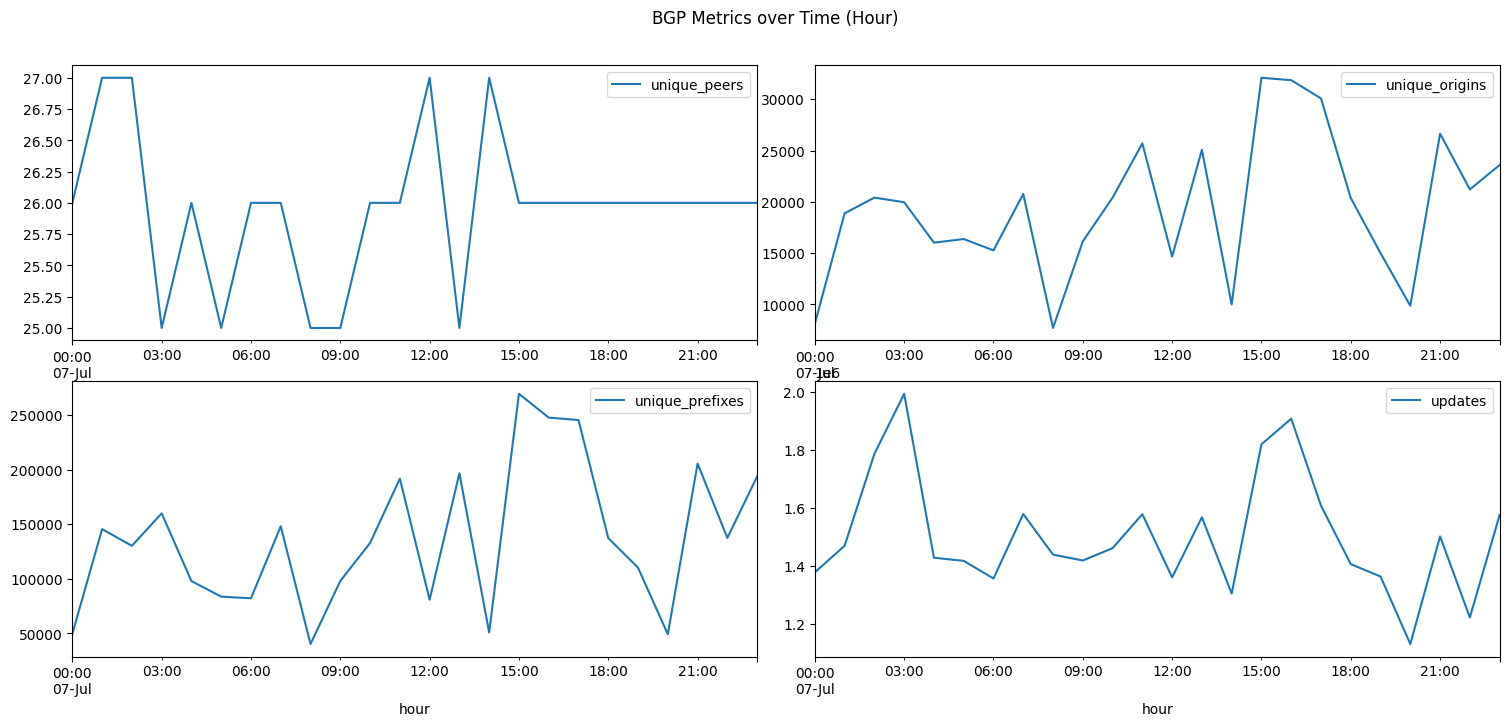

In [77]:
plot_metrics_over_time(df_agg_pd, 'hour')

In [52]:
# spark.stop()